In [1]:
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

import h5py as h5

import numpy as np

import gvar as gv

from tqdm.auto import tqdm

from lsqfit import nonlinear_fit

from copy import deepcopy

from itertools import product

from pathlib import Path

import lib_perylene as perylene

import plotting

import fitter

import scipy.stats as sps

%matplotlib inline

In [2]:
class ParamSpace():
    def __init__(self, Nts = None, betas = None, Us = None, mus = None):
        if Nts is None:
            self.Nts = np.array([32,64,96])
            # self.Nts = np.array([64,96])
        else:
            self.Nts = Nts
            
        if betas is None:
            self.betas = np.array([4,6,8])
            # self.betas = np.array([6,8])
        else:
            self.betas = betas
            
        if Us is None:
            self.Us = [2]
        else:
            self.Us = Us
        
        if mus is None:
            self.mus = np.arange(21)*0.1
        else:
            self.mus = mus
        
        self.Nparams = len(self.Nts)*len(self.betas)*len(self.Us)*len(self.mus)

    def items(self):
        return product(
            self.Nts, self.betas, self.Us, self.mus
        )

    def toKey(self,Nt,beta,U,mu):
        return f"Nt{Nt:g}/beta{beta:g}/U{U:g}/mu{mu:g}"
   
Nx = 20
Nfit = 40
Nbst = 100
U = 2

reportFolder = Path("./ReportNbst")
CacheFolder  = Path("./CacheNbst")

paramSpace = ParamSpace(mus = np.arange(11)*0.1)
paramRelevant = paramSpace #ParamSpace(mus = np.arange(6)*0.1, Nts = [32,64])

In [3]:
def QNonInt(mu,beta = None):
    ev = perylene.quantum_numbers[:,2] + mu
    
    if beta is None:
        return 2 * np.sum(
            np.heaviside( ev, 0.5 )
        ) - Nx
    else:
        return 2 * np.sum(
            1/(np.exp( -beta * ev ) + 1)
        ) - Nx
    

In [4]:
def GrubbsTestStatistic(data,mean = None, std = None, alpha = 0.01) -> (int,float,bool):
    r"""
        This is adapted from 
        https://en.wikipedia.org/wiki/Grubbs%27s_test#Definition
        G = (max_{i} | X_i - \mu |) / (\sigma)
        with mean = \mu and std = \sigma
        we then identify if i for which the maximum was found is a outlier by 
        G > (N-1)/sqrt(N) * sqrt( t^2 / (N-2 + t^2)  )
        where t denotes the critical value of the t-distribution with N-2 dof and a signficance level of $\alpha/2N$
        return OutlierIndex[int], GStatistic[float], isOutlier[bool] 
    """
    if data.ndim != 1: raise RuntimeError("Grubbs test only implemented for 1D data")
    N = data.size 
    
    signficanceLevel = alpha / (2.0*N) 
    t = sps.t.isf(signficanceLevel, N - 2)
    G_target = ((N-1)/np.sqrt(N)) * np.sqrt( t**2 / (N-2+t**2) )

    if mean is None:
        mean = data.mean()
    if std is None:
        std  = data.std()
    
    diff  = np.abs(data - mean)
    
    imax = np.argmax( diff )

    G = diff[imax] / std

    imaxIsOutlier = G > G_target

    return imax, G, imaxIsOutlier

In [5]:
energies = {
        f"beta{beta:g}/mu{mu:g}": {
        "est": np.zeros((Nx,len(paramRelevant.Nts))),
        "err": np.zeros((Nx,len(paramRelevant.Nts))),
    }

    for beta,mu in product(paramRelevant.betas,paramRelevant.mus)
}
    
for beta,mu,(NtID,Nt) in (pbar:=tqdm(product(paramRelevant.betas,paramRelevant.mus,enumerate(paramRelevant.Nts)), total = len(list(paramSpace.items())))):
    ensemblePath = Path(f"Nt{Nt:g}/beta{beta:g}/U{U:g}/mu{mu:g}")

    fits_ = { f'irrepID{irrepID}':None for irrepID in range(Nx) }

    for irrepPath in (CacheFolder/ensemblePath).iterdir():
        irrepID = irrepPath.name
        
        files = list(enumerate(irrepPath.iterdir()))
        numFits = len(files)
        
        if numFits == 0:
            print(f"No fits done for Nt{Nt:g}/beta{beta:g}/U2/mu{mu:g}/{irrepID}")
            continue
            
        irrepID = int(irrepID[7:])
            
        E_bst = np.zeros( (Nbst,numFits) )        
        E_est = np.zeros( numFits )
        E_err = np.zeros( numFits )
        
        AIC_bst = np.zeros( (Nbst,numFits) )        
        AIC_est = np.zeros( numFits )
        
        noBst = False
        for iFile,file in files:
            with h5.File(file) as h5f:
                _, Nstate, ts, te = str(file.name).split('_')
                Nstate = int(Nstate[6:])                
                try:
                    E_bst[:,iFile] = h5f['FitResult/bst/E0'][()] if perylene.decayingCorr[f'mu{mu:g}/beta{beta:g}'][f'irrepID{irrepID}'] else -h5f['FitResult/bst/F0'][()]
                    AIC_bst[:,iFile] =  h5f['FitStatistic/AIC/bst'][()]
                except Exception as e:
                    #pbar.write(f"Failed to load bootstrap: {file}")
                    noBst = True
                    #raise e
                    
                E_est[iFile]   = h5f['FitResult/est/E0'][()] if perylene.decayingCorr[f'mu{mu:g}/beta{beta:g}'][f'irrepID{irrepID}'] else -h5f['FitResult/est/F0'][()]
                
                E_err[iFile] = h5f['FitResult/err/E0'][()] if perylene.decayingCorr[f'mu{mu:g}/beta{beta:g}'][f'irrepID{irrepID}'] else h5f['FitResult/err/F0'][()]

                AIC_est[iFile] =  h5f['FitStatistic/AIC/est'][()]
        # end for iFile,file
        # Remove outliers
        while True:
            imax, G, isOutlier = GrubbsTestStatistic(E_est, alpha = 0.05)

            if isOutlier:
                print(f"Found Outlier ({irrepID=}); Deleted index={imax}, {G=:g}: E={E_est[imax]:g}")
                E_est = np.delete( E_est, imax )
                E_err = np.delete( E_err, imax )
                AIC_est  = np.delete( AIC_est , imax )

                if not noBst:
                    E_bst = np.delete( E_bst, imax, axis = 1 )
                    AIC_bst  = np.delete( AIC_bst, imax, axis = 1 )
            else:
                break

        if noBst:
            modelAvg = fitter.modelAverage_raw(
                param_est = E_est, AIC_est = AIC_est,
                param_err = E_err,
            )             
        else:
            modelAvg = fitter.modelAverage_raw(
                param_est = E_est, AIC_est = AIC_est,
                param_bst = E_bst, AIC_bst = AIC_bst
            ) 
        energies[f"beta{beta:g}/mu{mu:g}"]['est'][irrepID,NtID] = modelAvg['est']
        energies[f"beta{beta:g}/mu{mu:g}"]['err'][irrepID,NtID] = modelAvg['err']
# end for beta,mu,(NtID,Nt)


  0%|          | 0/99 [00:00<?, ?it/s]

Found Outlier (irrepID=9); Deleted index=8, G=2.73001: E=0.486159
Found Outlier (irrepID=9); Deleted index=8, G=2.62398: E=0.563987
Found Outlier (irrepID=19); Deleted index=27, G=3.04661: E=-0.158415
Found Outlier (irrepID=19); Deleted index=16, G=3.63567: E=-0.193356
Found Outlier (irrepID=19); Deleted index=148, G=4.76082: E=-0.244733
Found Outlier (irrepID=19); Deleted index=177, G=4.03349: E=-0.212763
Found Outlier (irrepID=19); Deleted index=29, G=4.12053: E=-0.209793
Found Outlier (irrepID=19); Deleted index=19, G=2.98284: E=1.01635
Found Outlier (irrepID=19); Deleted index=46, G=3.39669: E=0.595253
Found Outlier (irrepID=19); Deleted index=12, G=3.39097: E=0.5612
Found Outlier (irrepID=19); Deleted index=106, G=3.77982: E=0.666571
Found Outlier (irrepID=19); Deleted index=6, G=3.78924: E=0.642819
Found Outlier (irrepID=19); Deleted index=120, G=3.69975: E=0.607624
Found Outlier (irrepID=19); Deleted index=4, G=3.81907: E=0.599905
Found Outlier (irrepID=19); Deleted index=95, G=

In [6]:
from scipy.optimize import curve_fit

def continuumLimit(energies,paramSpace,U = 2):
    Nx = 20
    
    def model(delta,p):
        r"""
            delta: np.array of lattice spacings
            p    : parameters:
                p = {
                    E0: y-intercept, continuum value
                    E1: linear with delta
                    E2: quadratic with delta 
                    ...
                }
        """

        out = np.ones_like(delta,dtype=object)
        for key in p.keys():
            power = int(key[1])
            if power == 0: continue
            out += delta**power * p[key]
        out *= p['E0']
        return out

    def getP0(beta,mu,irrepID,terms):
        r"""
            Get the priors for the above fitmodel:
            
            mu: Chemical potential value
            irrep: integer 0,1...,19 identifying the irreducible repr.
            terms: List of terms ['E0','E1','E2',...]
        """

        p0 = gv.BufferDict()
        
        
        for key in terms:
            if key == 'E0':
                p0[key] = energies[f'beta{beta:g}/mu{mu:g}']['est'][irrepID][-1]
                # perylene.quantum_numbers[irrepID,2] + mu
            else:
                p0[key] = 0

        return p0
        
    results = {
        f"beta{beta:g}":{
            "Limits": np.empty( (len(paramSpace.mus), Nx), dtype=object ),
            "Econt": np.empty(  (len(paramSpace.mus), Nx), dtype=object ),
        }
        for beta in paramSpace.betas
    }

    for (i,mu),beta in product(enumerate(paramSpace.mus), paramSpace.betas):
        

        for irrepID in range(Nx):
            deltas = beta / np.array(paramSpace.Nts)
            ordinate = gv.gvar(energies[f'beta{beta:g}/mu{mu:g}']['est'][irrepID], energies[f'beta{beta:g}/mu{mu:g}']['err'][irrepID])
            
            # E(δ) = E₀ + δ E₁
            fit_1 = nonlinear_fit(
                udata  = (deltas, ordinate), 
                fcn   = model, 
                p0 = getP0(beta,mu,irrepID,['E0']) 
            )

            results[f"beta{beta:g}"]["Limits"][i,irrepID] = fit_1
            results[f"beta{beta:g}"]["Econt"][i,irrepID] = fit_1.p['E0'] #0.5 * ( fit_1.p['E0'] + fit_2.p['E0'])
            # results[f"beta{beta:g}"]["Econt"][i,irrepID] = (1/3) * ( np.sum(ordinate) )
    return results

results = continuumLimit(energies,paramRelevant)


In [27]:
def plotEnergyCont(results, paramSpace):
    Nx = 20
    Nplot = 20

    numRows = len(paramSpace.mus)
    numCols = len(paramSpace.betas)
    colors = list(plotting.style.COLORS.values())
    colorIndex = lambda k: (k * 7) % len(colors)

    irreps = range(Nx)

    pbar = tqdm( total = len(paramSpace.betas)*len(paramSpace.mus)*Nx )
    for irrepID in irreps:
        fig,axs = plt.subplots(
            numRows,
            numCols,
            figsize=(16.5, 23.3), # DIN A2
            #figsize = (23.3, 33.1), # DIN A1
            sharex = 'col',
            sharey = 'row',
            squeeze = False
        )

        handles = [None] * len(paramSpace.betas)

        colorKey = ['primary', 'complementary', 'highlight']
        #NstateMarker = [ 'o','x','^'] # [r'$1$',r'$2$',r'$3$']

        for ibeta, beta in enumerate(paramSpace.betas):
            for imu,mu in enumerate(paramSpace.mus):
                fit = results[f"beta{beta:g}"]["Limits"][imu,irrepID]
                if fit is None:
                    print(f"beta={beta:g}, mu={mu:g}")
                    print(results[f"beta{beta:g}"]["Econt"])
                    continue
                Econt = results[f"beta{beta:g}"]["Econt"][imu,irrepID]
                deltas = fit.x
                Energy = fit.y
                dof = fit.dof
                chi2dof= fit.chi2/dof

                abscissa = np.linspace(0,np.max(deltas),Nplot)
                ordinate = fit.fcn(abscissa,fit.p)

                # Plot best fit:
                axs[imu,ibeta].plot(
                    abscissa, gv.mean(ordinate), '-', color = plotting.style.MAIN_COLORS[colorKey[ibeta]],
                    label = rf"$^{{\chi^2}}/_\mathrm{{dof}} = {chi2dof:g}$"
                )
                axs[imu,ibeta].fill_between(
                    abscissa,
                    gv.mean(ordinate)+gv.sdev(ordinate),
                    gv.mean(ordinate)-gv.sdev(ordinate),
                    color = plotting.style.MAIN_COLORS[colorKey[ibeta]],
                    alpha = 0.2
                )

                # Plot Continuum Value
                axs[imu,ibeta].errorbar(
                    [0], [Econt.mean], yerr=[Econt.sdev],
                    capsize = 2,
                    fmt = '^',
                    color = colors[colorIndex(irrepID)],
                )

                # Plot the initial data
                for delta,E in zip( deltas,Energy ):
                    Nt = int( beta/delta  )
                    marker = 'o'

                    axs[imu,ibeta].errorbar(
                        [delta], [gv.mean(E)], yerr=[gv.sdev(E)],
                        capsize = 2,
                        marker = marker,
                        color = plotting.style.MAIN_COLORS[colorKey[ibeta]],
                    )

                # Set labels

                # axs[imu,ibeta].set_title(
                #     rf"$\beta = {beta:g}, \, \mu = {mu:g}, \, ^{{\chi^2}}/_\mathrm{{dof}} \, [\mathrm{{dof}}] = {chi2dof:g} \, [{dof}]$",
                #     fontsize=18
                # )
                axs[imu,ibeta].legend(fontsize = 18, loc = 'upper right')
                axs[imu,0].set_ylabel(r'$E(\delta)$',fontsize = 18)
                axs[imu,2].set_ylabel(rf'$\mu = {mu:g}$',fontsize = 18)
                axs[imu,2].yaxis.set_label_position("right")
                axs[imu,0].tick_params(axis='both', which='both', labelsize=18)
                pbar.update(1)
            # end for imu,mu
            axs[-1,ibeta].set_xlabel(r'$\delta$'   ,fontsize = 18)
        # end for ibeta, beta
        axs[0,0].set_title(rf"$\beta = {4:g}$",fontsize=18)
        axs[0,1].set_title(rf"$\beta = {6:g}$",fontsize=18)
        axs[0,2].set_title(rf"$\beta = {8:g}$",fontsize=18)
        fig.tight_layout()
        plotPath = Path(reportFolder)/'ContinuumLimits'
        plotPath.mkdir(parents=True,exist_ok=True)
        fig.savefig(plotPath/f"energyContLimit_irrepID{irrepID}.pdf", dpi=10)
        plt.close(fig)
    # end for irrepID
# end plotEnergyCont

plotEnergyCont(results, paramRelevant)

  0%|          | 0/660 [00:00<?, ?it/s]

In [8]:
def plotEnergyContPerMu(results, paramSpace, U = 2):
    Nx = 20 
    Nplot = 20
    
    numCols = 6 
    numRows = 4
    colors = list(plotting.style.COLORS.values())
    colorIndex = lambda k: (k * 7) % len(colors)


    irreps = range(Nx)

    pbar = tqdm( total = len(paramSpace.betas)*len(irreps) )
    colorKey = ['primary', 'complementary', 'highlight']

    for ibeta, beta in enumerate(paramSpace.betas):
        mus = paramSpace.mus
            
        fig,axs = plt.subplots(
            numRows,
            numCols,
            figsize=(23.3, 16.5), # DIN A2
            squeeze = False
        )

        for irrepID in irreps:
            if irrepID in [0,1,2,3,4,5]: 
                row,col = 0,irrepID
            elif irrepID in [6,7,8,9]: 
                row,col = 1, irrepID-6
                axs[row,4].set_axis_off()
                axs[row,5].set_axis_off()
                # axs[1,6].set_axis_off()
            elif irrepID in [10,11,12,13,14,15]:
                row,col = 2, irrepID-10                
            elif irrepID in [16,17,18,19]: 
                row,col = 3, irrepID-16
                axs[row,4].set_axis_off()
                axs[row,5].set_axis_off()
                # axs[1,5].set_axis_off()
                
            Econt = results[f"beta{beta}"]["Econt"][:,irrepID]
            
            axs[row,col].errorbar(
                mus, gv.mean(Econt), yerr = gv.sdev(Econt), fmt = '^:', color = colors[colorIndex(irrepID)],capsize=2,
                label = r"$U=2$"
            )

            abscissa = np.linspace(np.min(mus), np.max(mus), Nplot)
            axs[row,col].plot( 
                abscissa, perylene.quantum_numbers[irrepID,2] + abscissa, 'k-',
                label = r"$U=0$"
            )

            axs[row,col].set_xlabel(r'$\mu$', fontsize = 16)
            axs[row,col].set_ylabel(r'$E_\mathrm{cont}(\mu)$', fontsize = 16)
            axs[row,col].set_title( rf"{perylene.D2irreps[irrepID]}",fontsize=18 )
            axs[row,col].legend(fontsize=14)

            pbar.update(1)
        
        fig.tight_layout()
        plotPath = Path(reportFolder)/'ContinuumLimits'
        plotPath.mkdir(parents=True,exist_ok=True)
        fig.savefig(plotPath/f"EcontPerMu_beta{beta:g}.pdf", dpi=10)
        plt.close(fig)
    # end for ibeta,beta 
# end plotEnergyCont


print("Plotting Continuum limit of E...")
plotEnergyContPerMu(results, paramRelevant)
print("Done")

Plotting Continuum limit of E...


  0%|          | 0/60 [00:00<?, ?it/s]

Done


Plotting...
Done.


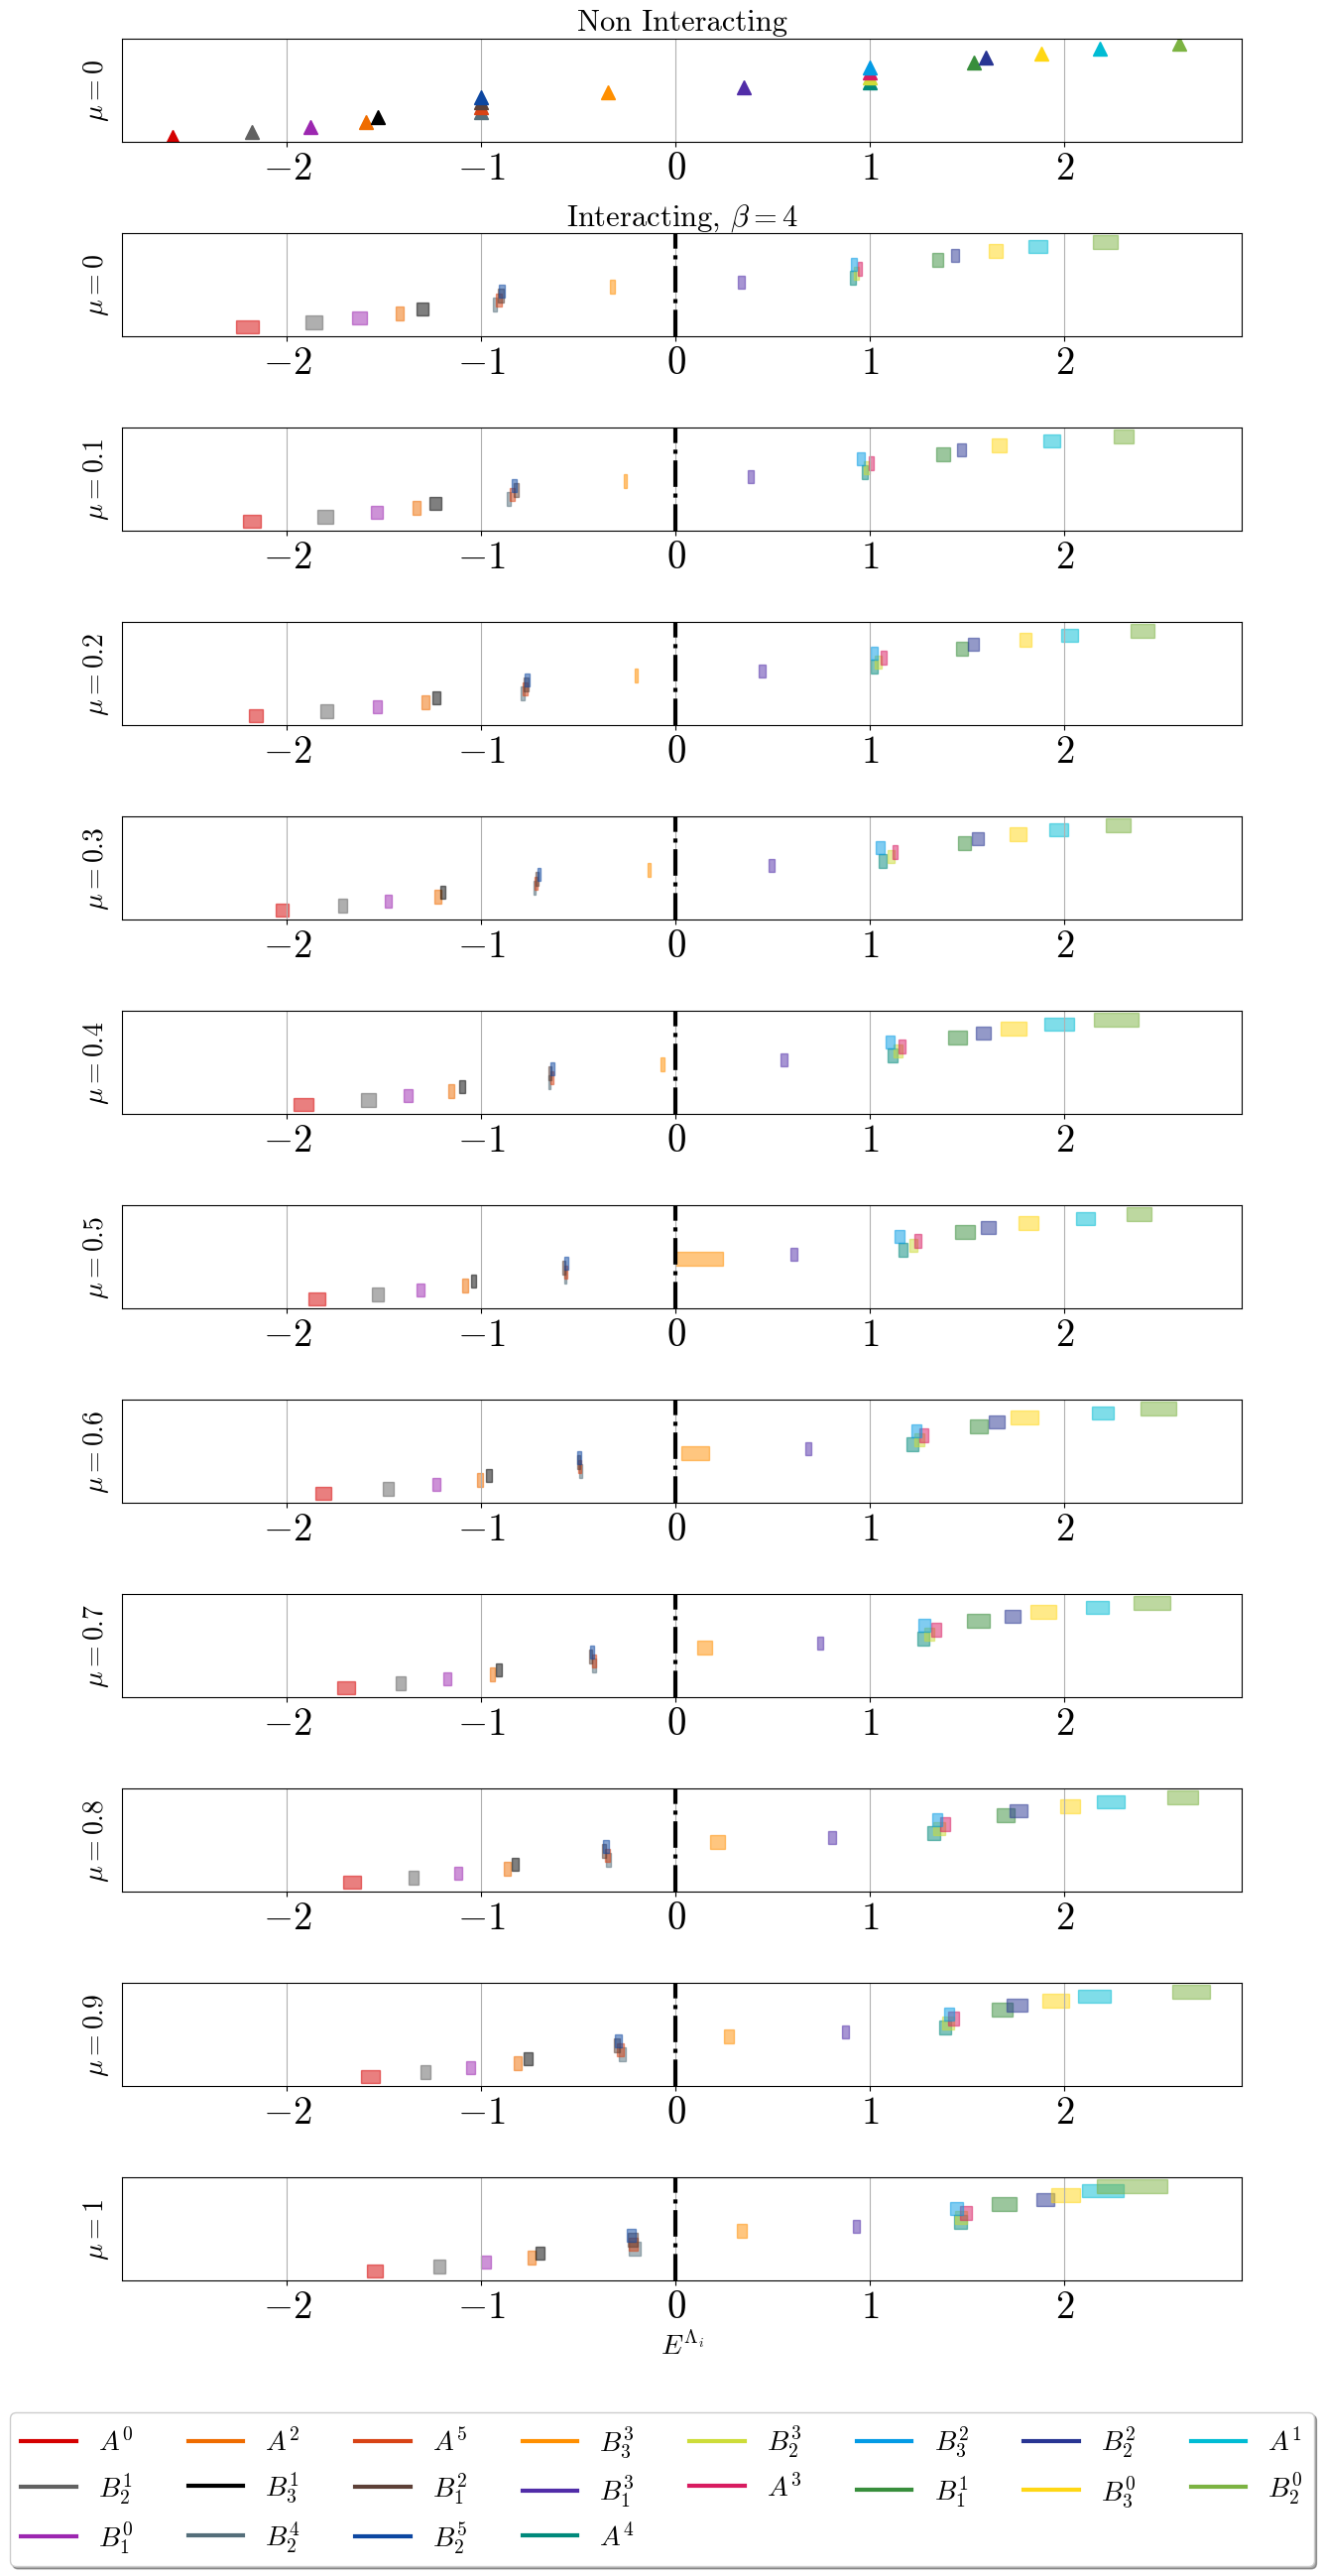

<Figure size 1200x2400 with 0 Axes>

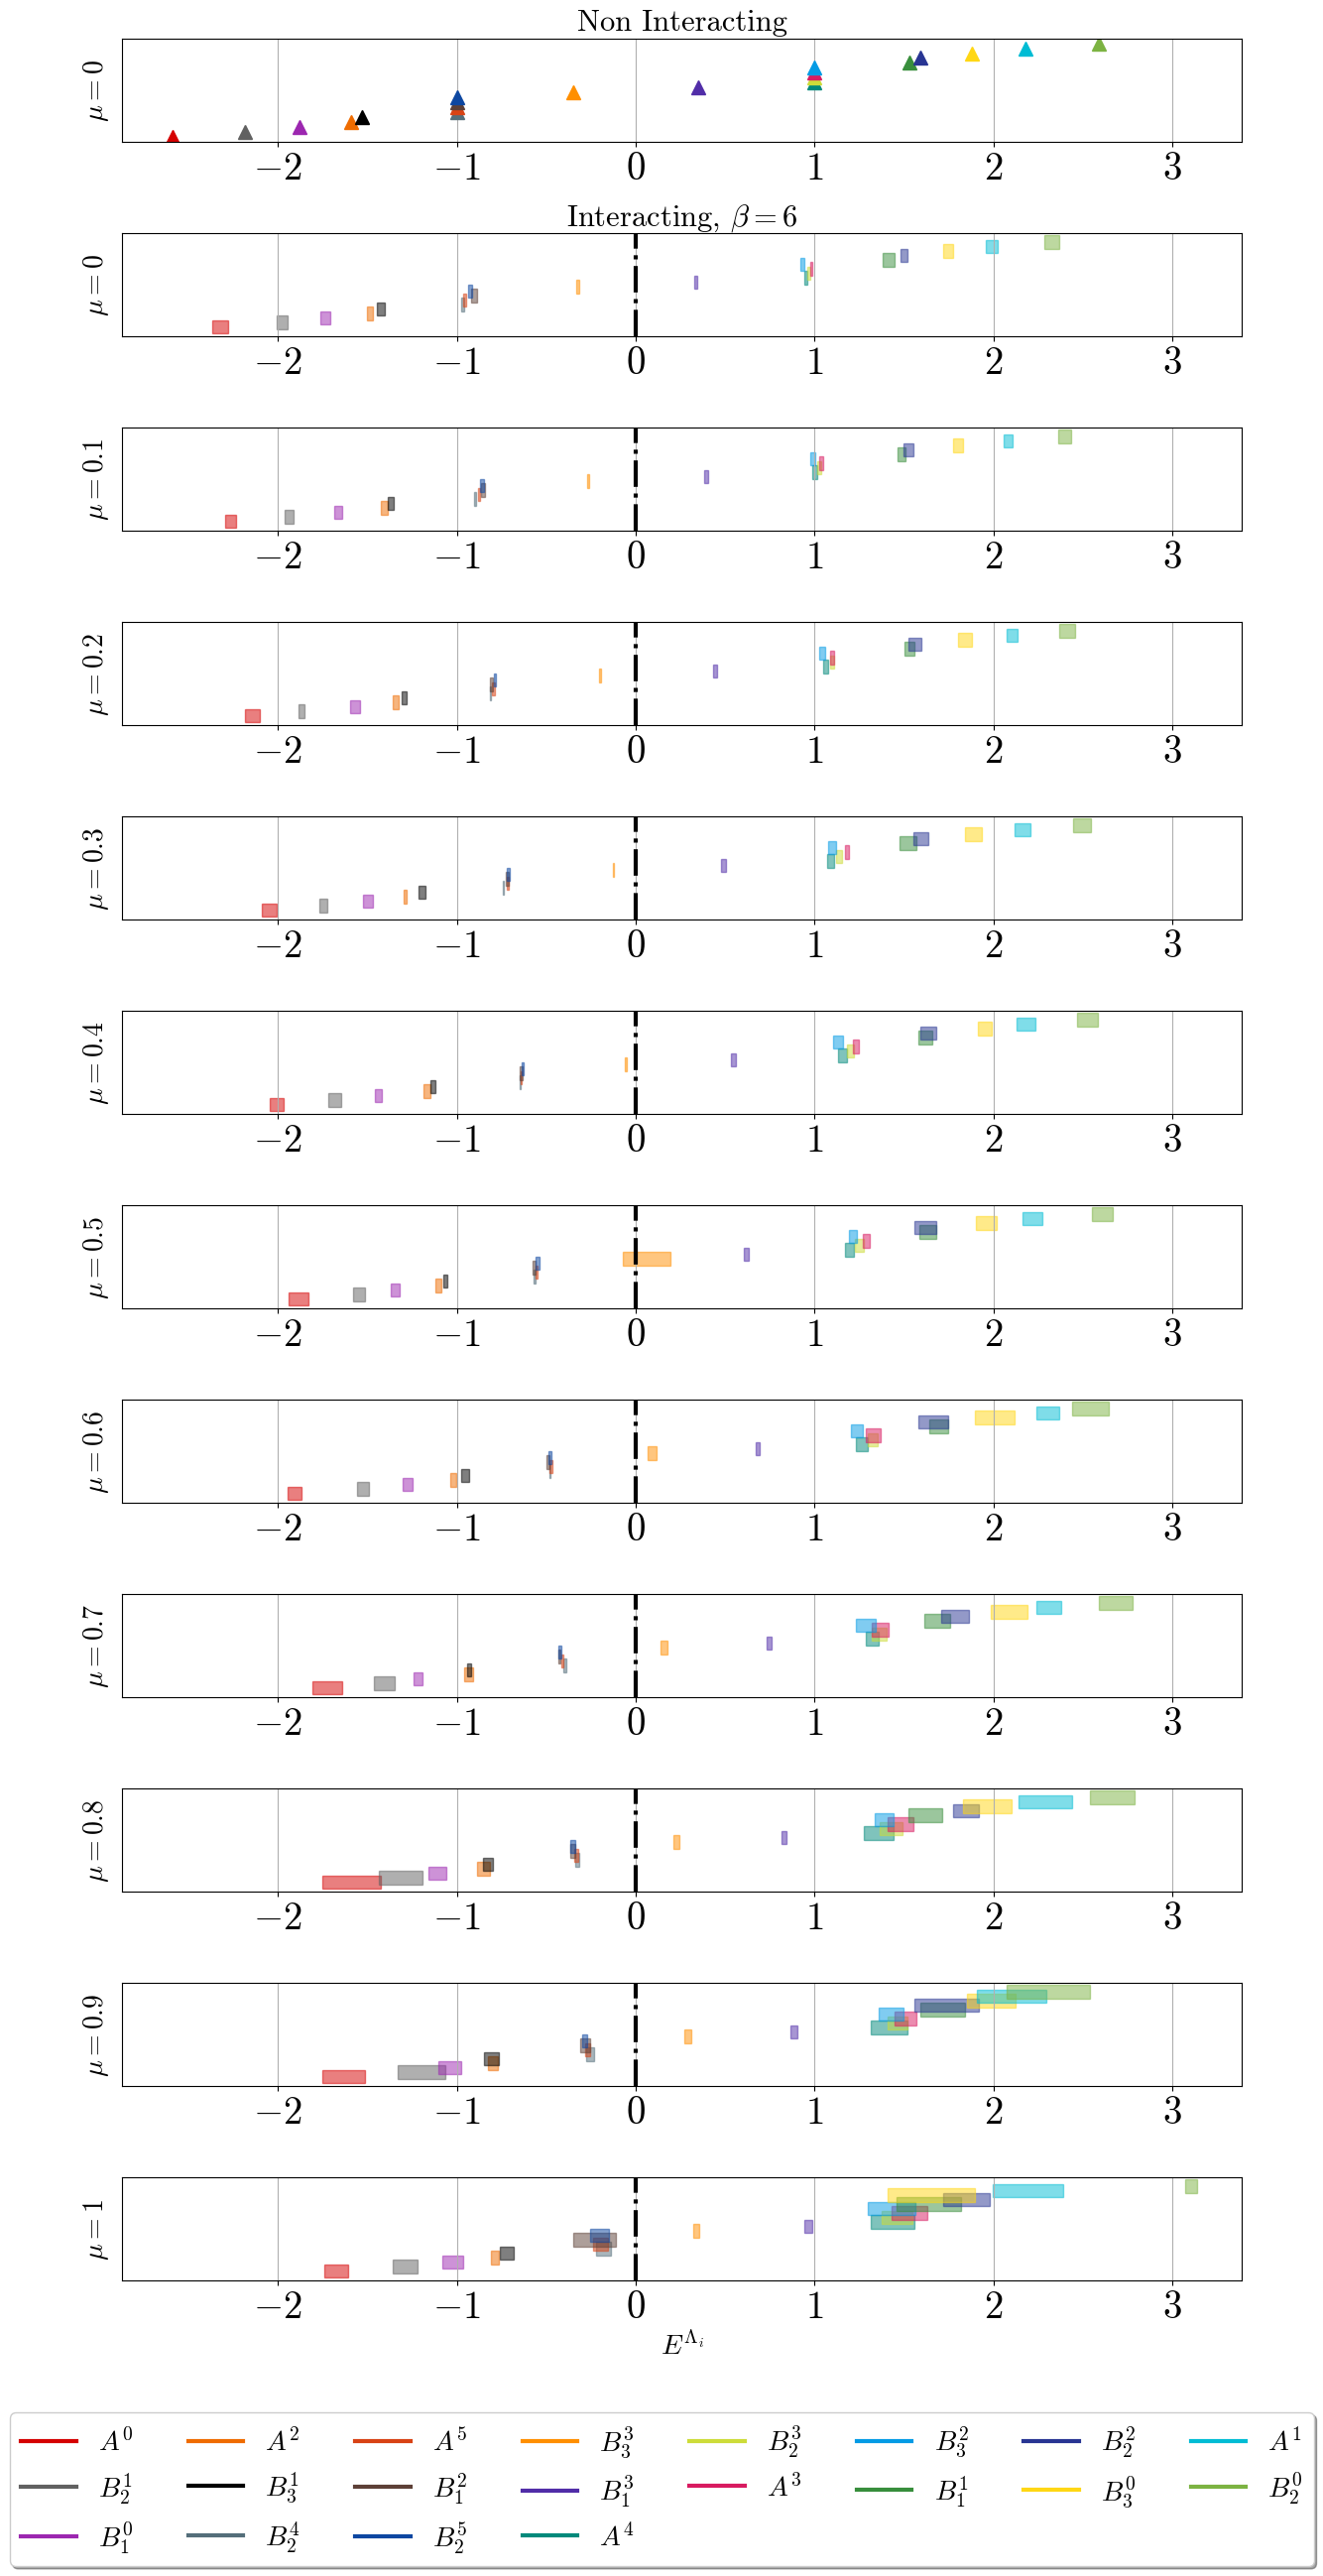

<Figure size 1200x2400 with 0 Axes>

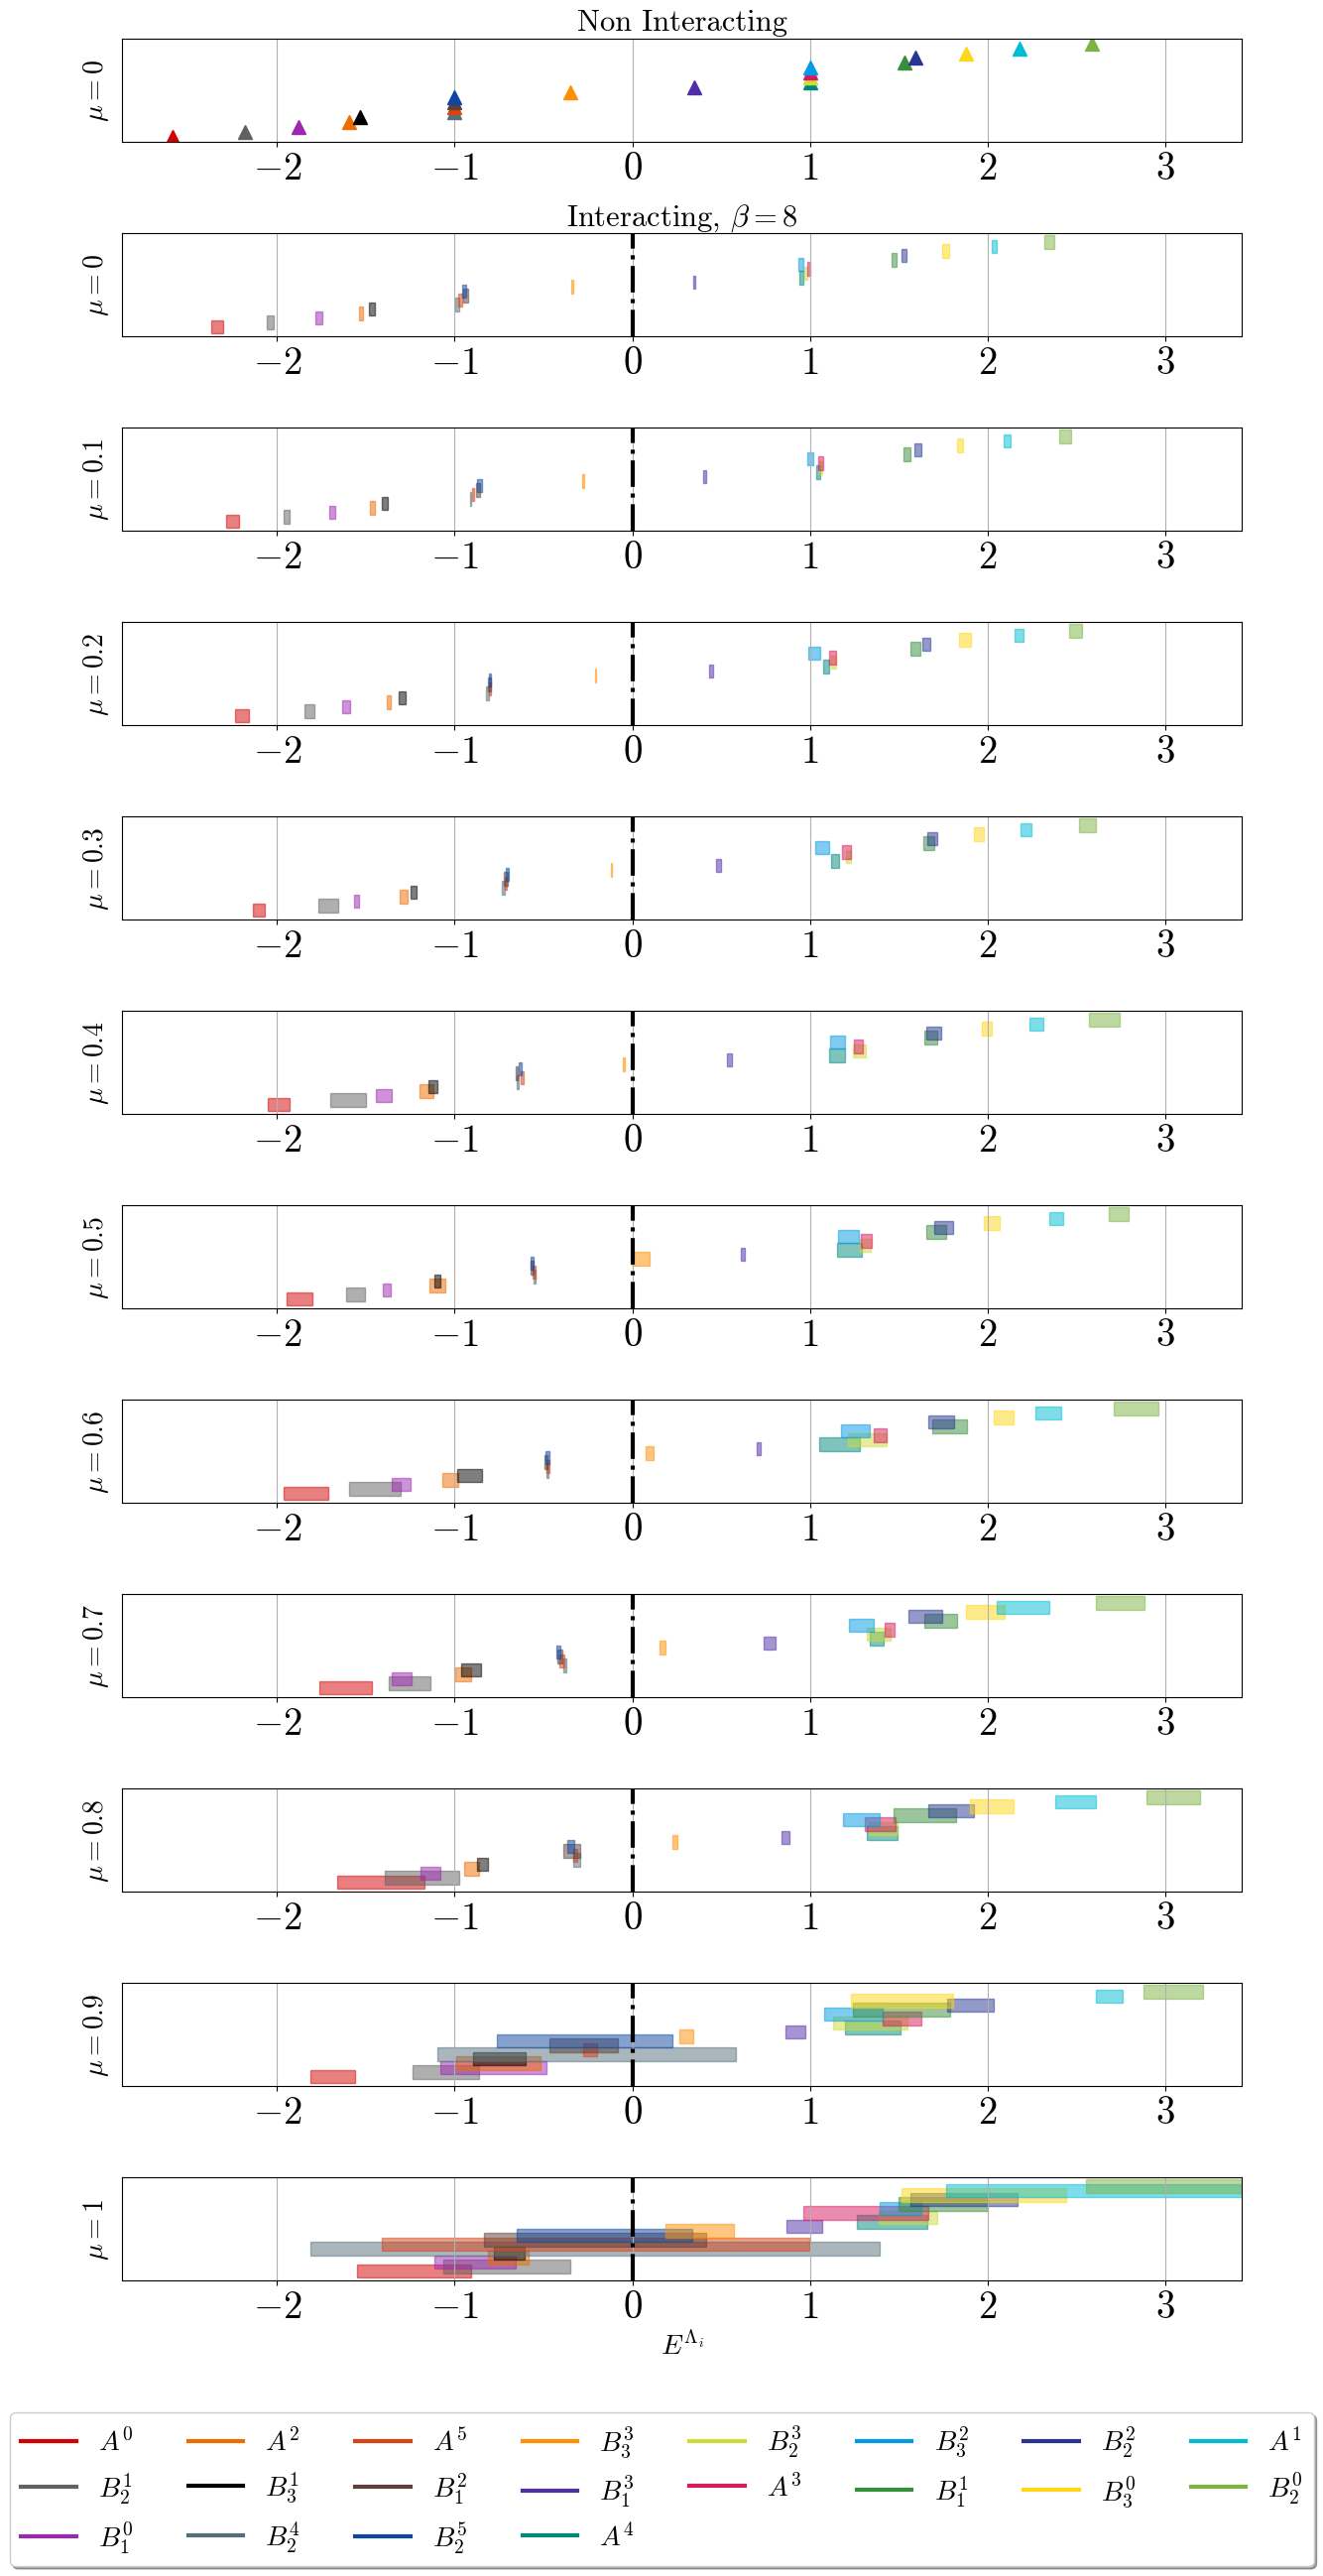

<Figure size 1200x2400 with 0 Axes>

In [9]:
def plotSpectrum(results,paramSpace):

    colors = list(plotting.style.COLORS.values())
    colorIndex = lambda k: (k * 7) % len(colors)

    for ibeta, beta in enumerate(paramSpace.betas):

        fig,axs = plt.subplots(
            len(paramSpace.mus)+1,
            1,
            #figsize=(12,24),
            figsize=(12, 24),
            sharex='col'
        )
        
        handles = []
    
        sort = np.argsort(perylene.quantum_numbers[:,2]) 
        it = reversed(colors)
        for ik,(k,key) in enumerate(zip(sort,it)):
            axs[0].plot(
                perylene.quantum_numbers[k,2], ik, '^', color =  colors[colorIndex(k)]
            )
        axs[0].set_title("Non Interacting", fontsize = 22)
        axs[0].set_ylabel(fr"$\mu={0:g}$", fontsize = 20)
        axs[0].set_yticks([])
        axs[0].xaxis.set_tick_params(which='both', labelbottom=True)
        axs[0].grid()
        axs[1].set_title(rf"Interacting, $\beta={beta}$", fontsize = 22)
        
        for imu, mu in enumerate( paramSpace.mus ):        
            row = imu + 1
    
            axs[row].axvline(
                0, linestyle='-.', color = 'k' 
            )
        
            for ik,(k,key) in enumerate(zip(sort,colors)):
                fit   =  results[f'beta{beta}']['Limits'][imu,k]
                E_est =  results[f'beta{beta}']['Econt'][imu,k].mean
                E_err =  results[f'beta{beta}']['Econt'][imu,k].sdev
                
                handle, = axs[row].plot(
                    E_est,ik, '',
                    color = colors[colorIndex(k)],
                    label = perylene.D2irreps[k],
                )
                
                axs[row].add_artist(Rectangle(
                    xy = (E_est - E_err, ik-1.5),
                    width = 2*E_err,
                    height = 3,
                    color = colors[colorIndex(k)],
                    alpha = 0.5
                ))
    
                if mu == 0:
                    handles.append(handle)
            axs[row].set_ylabel(fr"$\mu = {mu:g}$", fontsize = 20)
            axs[row].set_yticks([])
            axs[row].set_ylim(-2,21)
            axs[row].xaxis.set_tick_params(which='both', labelbottom=True)
            axs[row].grid()
    
        handles_v2 = deepcopy(handles);
        [h.set_marker('s') for h in handles_v2]
        
        axs[-1].set_xlabel(r"$E^{\Lambda_i}$", fontsize = 20)
        lgd = fig.legend(handles = handles,loc='upper center', 
            bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=8, fontsize = 20)
    
        fig.tight_layout()
        plotPath = Path(reportFolder)/'ContinuumLimits'
        plotPath.mkdir(parents=True,exist_ok=True)
        fig.savefig(plotPath/f"spectrum_beta{beta:g}.pdf", dpi=10, bbox_inches='tight')
        plt.clf()
        # plt.close()
    # end for ibeta,beta
# end plotSpectrum

print("Plotting...")
plotSpectrum(results, paramRelevant );
print("Done.")

In [10]:
import pandas as pd

def formatData(results,beta, subset = np.s_[:]):

    df = pd.DataFrame( results[f"beta{beta}"]["Econt"][:,subset], index= [f"{mu:g}" for mu in paramRelevant.mus], columns = perylene.D2irreps[subset])
    
    df.index.name=r'$\mu$'
    df = df.style.set_caption(rf"Summary of $E_\mathrm{{cont}}$ at $\beta={beta:g}$").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('font-size', '20px')
        ]
    }])

    return df

In [11]:
formatData(results,beta=4)

,$A^0$,$A^1$,$A^2$,$A^3$,$A^4$,$A^5$,$B_1^0$,$B_1^1$,$B_1^2$,$B_1^3$,$B_2^0$,$B_2^1$,$B_2^2$,$B_2^3$,$B_2^4$,$B_2^5$,$B_3^0$,$B_3^1$,$B_3^2$,$B_3^3$
$\mu$,,,,,,,,,,,,,,,,,,,,
0,-2.202(59),1.861(49),-1.420(21),0.945(10),0.911(15),-0.910(15),-1.627(37),1.348(28),-0.902(15),0.338(16),2.208(62),-1.861(43),1.435(21),0.927(13),-0.932(12),-0.896(15),1.647(36),-1.305(30),0.917(14),-0.328(12)
0.1,-2.182(46),1.933(44),-1.334(21),1.004(12),0.970(16),-0.841(12),-1.537(31),1.373(35),-0.822(14),0.386(14),2.306(51),-1.802(42),1.470(25),0.980(15),-0.8605(94),-0.833(13),1.663(39),-1.237(29),0.952(19),-0.2596(96)
0.2,-2.161(37),2.025(44),-1.288(19),1.068(14),1.019(18),-0.775(11),-1.535(24),1.471(31),-0.772(13),0.444(16),2.402(62),-1.796(35),1.530(29),1.041(17),-0.7890(90),-0.766(12),1.797(31),-1.233(21),1.022(19),-0.2026(87)
0.3,-2.025(33),1.968(49),-1.224(16),1.126(14),1.064(21),-0.7187(61),-1.479(19),1.486(34),-0.7135(89),0.493(17),2.276(63),-1.715(23),1.552(31),1.107(16),-0.7275(52),-0.7031(93),1.762(44),-1.198(13),1.052(22),-0.1359(84)
0.4,-1.916(50),1.973(76),-1.155(15),1.163(19),1.115(23),-0.6385(77),-1.378(23),1.450(49),-0.6473(79),0.556(16),2.27(11),-1.582(39),1.583(38),1.142(21),-0.6488(54),-0.6356(87),1.739(66),-1.099(16),1.102(25),-0.068(11)
0.5,-1.847(42),2.106(48),-1.083(14),1.243(18),1.168(25),-0.5663(66),-1.313(22),1.489(51),-0.5750(78),0.608(16),2.385(64),-1.533(29),1.607(40),1.224(20),-0.5674(62),-0.5630(88),1.813(52),-1.040(14),1.151(25),0.12(12)
0.6,-1.814(39),2.197(58),-1.007(15),1.277(22),1.218(30),-0.4947(74),-1.233(20),1.559(46),-0.5001(91),0.681(16),2.481(91),-1.480(28),1.650(43),1.251(26),-0.4904(73),-0.4955(96),1.794(73),-0.962(16),1.236(25),0.098(71)
0.7,-1.694(46),2.170(59),-0.944(14),1.339(24),1.274(30),-0.420(10),-1.175(20),1.557(60),-0.4380(91),0.742(16),2.449(95),-1.415(24),1.732(41),1.304(26),-0.4208(92),-0.430(11),1.892(66),-0.908(16),1.278(29),0.149(37)
0.8,-1.667(46),2.237(71),-0.868(18),1.386(26),1.327(31),-0.351(13),-1.120(20),1.695(45),-0.368(11),0.803(18),2.608(78),-1.350(25),1.761(45),1.355(29),-0.346(13),-0.357(16),2.027(50),-0.828(19),1.345(27),0.216(37)


In [12]:
print(
    formatData(results,beta=4, subset = np.s_[0 :10]).to_latex(),
    formatData(results,beta=4, subset = np.s_[10:20]).to_latex()
)

\begin{table}
\caption{Summary of $E_\mathrm{cont}$ at $\beta=4$}
\begin{tabular}{lllllllllll}
 & $A^0$ & $A^1$ & $A^2$ & $A^3$ & $A^4$ & $A^5$ & $B_1^0$ & $B_1^1$ & $B_1^2$ & $B_1^3$ \\
$\mu$ &  &  &  &  &  &  &  &  &  &  \\
0 & -2.202(59) & 1.861(49) & -1.420(21) & 0.945(10) & 0.911(15) & -0.910(15) & -1.627(37) & 1.348(28) & -0.902(15) & 0.338(16) \\
0.1 & -2.182(46) & 1.933(44) & -1.334(21) & 1.004(12) & 0.970(16) & -0.841(12) & -1.537(31) & 1.373(35) & -0.822(14) & 0.386(14) \\
0.2 & -2.161(37) & 2.025(44) & -1.288(19) & 1.068(14) & 1.019(18) & -0.775(11) & -1.535(24) & 1.471(31) & -0.772(13) & 0.444(16) \\
0.3 & -2.025(33) & 1.968(49) & -1.224(16) & 1.126(14) & 1.064(21) & -0.7187(61) & -1.479(19) & 1.486(34) & -0.7135(89) & 0.493(17) \\
0.4 & -1.916(50) & 1.973(76) & -1.155(15) & 1.163(19) & 1.115(23) & -0.6385(77) & -1.378(23) & 1.450(49) & -0.6473(79) & 0.556(16) \\
0.5 & -1.847(42) & 2.106(48) & -1.083(14) & 1.243(18) & 1.168(25) & -0.5663(66) & -1.313(22) & 1.489(51) & -0.57

In [13]:
formatData(results,beta=6)

,$A^0$,$A^1$,$A^2$,$A^3$,$A^4$,$A^5$,$B_1^0$,$B_1^1$,$B_1^2$,$B_1^3$,$B_2^0$,$B_2^1$,$B_2^2$,$B_2^3$,$B_2^4$,$B_2^5$,$B_3^0$,$B_3^1$,$B_3^2$,$B_3^3$
$\mu$,,,,,,,,,,,,,,,,,,,,
0,-2.324(44),1.991(34),-1.486(17),0.9809(67),0.9507(93),-0.9555(98),-1.735(26),1.414(31),-0.904(15),0.3368(88),2.327(41),-1.976(32),1.502(19),0.9671(82),-0.9688(89),-0.925(12),1.749(29),-1.425(21),0.931(13),-0.3233(91)
0.1,-2.264(29),2.083(27),-1.407(20),1.036(11),1.003(13),-0.8759(77),-1.663(22),1.486(23),-0.855(11),0.393(10),2.399(38),-1.938(24),1.526(27),1.027(11),-0.8959(57),-0.857(10),1.804(28),-1.369(15),0.989(15),-0.2649(62)
0.2,-2.142(41),2.106(30),-1.339(16),1.099(13),1.064(14),-0.7941(69),-1.569(25),1.531(26),-0.8071(64),0.443(12),2.414(44),-1.869(17),1.560(36),1.100(12),-0.8120(54),-0.7867(81),1.841(37),-1.296(13),1.042(17),-0.1988(44)
0.3,-2.047(42),2.163(45),-1.2889(87),1.182(13),1.089(20),-0.7137(70),-1.497(26),1.523(46),-0.7194(76),0.493(14),2.496(49),-1.745(24),1.595(43),1.137(17),-0.7390(30),-0.7130(70),1.889(45),-1.194(18),1.097(22),-0.1245(48)
0.4,-2.005(39),2.181(54),-1.167(17),1.232(17),1.157(25),-0.6405(44),-1.437(19),1.619(39),-0.6403(77),0.547(14),2.524(58),-1.684(37),1.635(45),1.200(20),-0.6436(36),-0.6326(70),1.952(40),-1.132(15),1.131(26),-0.0535(56)
0.5,-1.886(55),2.217(54),-1.101(15),1.290(20),1.194(26),-0.5551(62),-1.344(23),1.633(46),-0.5662(73),0.618(13),2.610(58),-1.546(33),1.620(62),1.253(25),-0.5659(38),-0.5485(85),1.962(57),-1.063(13),1.216(21),0.06(13)
0.6,-1.905(38),2.306(63),-1.021(17),1.330(43),1.266(33),-0.4720(78),-1.277(28),1.696(53),-0.4917(82),0.683(13),2.54(10),-1.523(34),1.663(83),1.327(28),-0.4799(47),-0.4776(88),2.01(11),-0.954(22),1.236(32),0.092(27)
0.7,-1.724(85),2.309(68),-0.934(24),1.367(47),1.323(36),-0.4106(67),-1.217(27),1.684(72),-0.4274(58),0.746(13),2.685(95),-1.406(59),1.786(78),1.362(40),-0.3944(81),-0.4224(85),2.09(10),-0.930(13),1.285(55),0.160(20)
0.8,-1.59(17),2.29(15),-0.850(38),1.483(72),1.358(82),-0.330(12),-1.111(50),1.620(92),-0.352(15),0.829(14),2.66(12),-1.31(12),1.846(71),1.430(62),-0.326(12),-0.352(13),1.97(14),-0.826(27),1.391(52),0.228(17)


In [14]:
print(
    formatData(results, beta=6, subset=np.s_[0:10]).to_latex(),
    formatData(results, beta=6, subset=np.s_[10:20]).to_latex(),
)

\begin{table}
\caption{Summary of $E_\mathrm{cont}$ at $\beta=6$}
\begin{tabular}{lllllllllll}
 & $A^0$ & $A^1$ & $A^2$ & $A^3$ & $A^4$ & $A^5$ & $B_1^0$ & $B_1^1$ & $B_1^2$ & $B_1^3$ \\
$\mu$ &  &  &  &  &  &  &  &  &  &  \\
0 & -2.324(44) & 1.991(34) & -1.486(17) & 0.9809(67) & 0.9507(93) & -0.9555(98) & -1.735(26) & 1.414(31) & -0.904(15) & 0.3368(88) \\
0.1 & -2.264(29) & 2.083(27) & -1.407(20) & 1.036(11) & 1.003(13) & -0.8759(77) & -1.663(22) & 1.486(23) & -0.855(11) & 0.393(10) \\
0.2 & -2.142(41) & 2.106(30) & -1.339(16) & 1.099(13) & 1.064(14) & -0.7941(69) & -1.569(25) & 1.531(26) & -0.8071(64) & 0.443(12) \\
0.3 & -2.047(42) & 2.163(45) & -1.2889(87) & 1.182(13) & 1.089(20) & -0.7137(70) & -1.497(26) & 1.523(46) & -0.7194(76) & 0.493(14) \\
0.4 & -2.005(39) & 2.181(54) & -1.167(17) & 1.232(17) & 1.157(25) & -0.6405(44) & -1.437(19) & 1.619(39) & -0.6403(77) & 0.547(14) \\
0.5 & -1.886(55) & 2.217(54) & -1.101(15) & 1.290(20) & 1.194(26) & -0.5551(62) & -1.344(23) & 1.633(46)

In [15]:
formatData(results,beta=8)

,$A^0$,$A^1$,$A^2$,$A^3$,$A^4$,$A^5$,$B_1^0$,$B_1^1$,$B_1^2$,$B_1^3$,$B_2^0$,$B_2^1$,$B_2^2$,$B_2^3$,$B_2^4$,$B_2^5$,$B_3^0$,$B_3^1$,$B_3^2$,$B_3^3$
$\mu$,,,,,,,,,,,,,,,,,,,,
0,-2.337(36),2.038(16),-1.529(12),0.9917(85),0.951(12),-0.9696(92),-1.763(20),1.476(14),-0.938(16),0.3477(68),2.350(28),-2.037(18),1.530(12),0.9758(77),-0.9870(96),-0.949(12),1.766(18),-1.467(17),0.949(13),-0.3376(74)
0.1,-2.253(37),2.112(19),-1.463(13),1.061(12),1.046(11),-0.8969(50),-1.689(18),1.547(19),-0.869(12),0.4090(86),2.438(34),-1.946(18),1.606(20),1.0622(78),-0.9099(44),-0.859(14),1.848(17),-1.392(16),1.005(17),-0.2757(50)
0.2,-2.197(38),2.176(25),-1.373(11),1.127(21),1.092(19),-0.8010(69),-1.611(20),1.596(29),-0.8041(92),0.445(13),2.496(35),-1.819(26),1.655(22),1.134(12),-0.8163(65),-0.8027(72),1.873(32),-1.297(21),1.025(33),-0.2057(30)
0.3,-2.102(35),2.218(31),-1.289(23),1.205(25),1.143(23),-0.7123(75),-1.551(14),1.669(31),-0.712(11),0.484(15),2.563(47),-1.714(55),1.691(28),1.219(15),-0.7259(76),-0.7061(85),1.953(26),-1.233(18),1.070(37),-0.1180(44)
0.4,-1.992(63),2.276(41),-1.160(39),1.273(24),1.152(45),-0.6201(94),-1.400(43),1.680(38),-0.6515(59),0.546(13),2.658(87),-1.599(99),1.700(42),1.277(35),-0.6455(53),-0.6311(86),1.997(30),-1.121(25),1.157(41),-0.0472(72)
0.5,-1.872(73),2.388(40),-1.097(43),1.320(30),1.224(69),-0.5555(82),-1.383(24),1.711(54),-0.5635(99),0.621(13),2.737(56),-1.561(53),1.753(51),1.311(30),-0.5514(59),-0.5643(83),2.025(46),-1.099(17),1.218(57),0.048(50)
0.6,-1.84(13),2.344(73),-1.025(46),1.396(38),1.17(11),-0.4762(78),-1.301(51),1.785(98),-0.4848(96),0.711(13),2.84(13),-1.45(15),1.740(71),1.32(11),-0.4763(68),-0.477(11),2.092(56),-0.917(70),1.254(81),0.099(22)
0.7,-1.61(15),2.20(15),-0.951(44),1.449(30),1.377(41),-0.398(12),-1.298(55),1.737(93),-0.409(13),0.772(33),2.75(14),-1.25(12),1.651(96),1.386(67),-0.380(10),-0.417(10),1.99(11),-0.906(55),1.289(69),0.172(18)
0.8,-1.42(25),2.50(12),-0.903(42),1.395(87),1.410(87),-0.323(12),-1.137(56),1.65(17),-0.341(46),0.864(22),3.05(15),-1.18(21),1.79(13),1.415(81),-0.311(19),-0.346(18),2.03(12),-0.844(29),1.29(10),0.240(12)


In [16]:
print(
    formatData(results,beta=8, subset = np.s_[0 :10]).to_latex(),
    formatData(results,beta=8, subset = np.s_[10:20]).to_latex()
)


\begin{table}
\caption{Summary of $E_\mathrm{cont}$ at $\beta=8$}
\begin{tabular}{lllllllllll}
 & $A^0$ & $A^1$ & $A^2$ & $A^3$ & $A^4$ & $A^5$ & $B_1^0$ & $B_1^1$ & $B_1^2$ & $B_1^3$ \\
$\mu$ &  &  &  &  &  &  &  &  &  &  \\
0 & -2.337(36) & 2.038(16) & -1.529(12) & 0.9917(85) & 0.951(12) & -0.9696(92) & -1.763(20) & 1.476(14) & -0.938(16) & 0.3477(68) \\
0.1 & -2.253(37) & 2.112(19) & -1.463(13) & 1.061(12) & 1.046(11) & -0.8969(50) & -1.689(18) & 1.547(19) & -0.869(12) & 0.4090(86) \\
0.2 & -2.197(38) & 2.176(25) & -1.373(11) & 1.127(21) & 1.092(19) & -0.8010(69) & -1.611(20) & 1.596(29) & -0.8041(92) & 0.445(13) \\
0.3 & -2.102(35) & 2.218(31) & -1.289(23) & 1.205(25) & 1.143(23) & -0.7123(75) & -1.551(14) & 1.669(31) & -0.712(11) & 0.484(15) \\
0.4 & -1.992(63) & 2.276(41) & -1.160(39) & 1.273(24) & 1.152(45) & -0.6201(94) & -1.400(43) & 1.680(38) & -0.6515(59) & 0.546(13) \\
0.5 & -1.872(73) & 2.388(40) & -1.097(43) & 1.320(30) & 1.224(69) & -0.5555(82) & -1.383(24) & 1.711(54) &